In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [6]:
import os
import random
import scipy.io
import keras
import tensorflow as tf
from google.colab.patches import cv2_imshow
import numpy as np
from glob import glob
from google.colab import drive
import matplotlib.pyplot as plt

from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, Flatten, Dense, MaxPooling2D
from keras.models import Sequential, load_model

drive.mount('/content/gdrive')   

Using TensorFlow backend.


Mounted at /content/gdrive


In [7]:
#Add your own path
FUSION2020_FOLDER_PATH = "/content/gdrive/My Drive/FUSION2020"
NUMBER_OF_EXAMPLES_FOR_EACH_CLASS = 60
NUMBER_OF_EXAMPLES_FOR_TRAINING_AND_VALIDATION = 15
NUMBER_OF_SAMPLES_TO_IGNORE = 0
RANDOM_TRAINING_AND_VALIDATION_EXAMPLES = False

In [8]:

# Function to get the list of training examples paths
# inputs:
#   path:str -> Path to folder with .mat files.
#   number_of_examples:int -> Number of examples to load for each class. Will be loaded examples from 1 to number_of_examples+1
#   random_examples -> Do we select random examples?
# outputs:
#    If random_examples is false, it returns the first number_of_examples examples from each class. Else, number_of_examples random examples.

def get_training_and_validation_example_list(path, number_of_examples, random_examples):
  if random_examples:
    all_examples_paths = glob(os.path.join(path, "*.mat"))
    np.random.shuffle(all_examples_paths)
    training_matrix_paths = all_examples_paths[:number_of_examples]
  else:
    training_matrix_paths = []
    for i in range(1, number_of_examples+1):
      training_matrix_paths = training_matrix_paths + glob(os.path.join(path, "*_{}.mat".format(i)))
  return training_matrix_paths

# Function to get the list of examples paths to ignore.
# inputs:
#   path:str -> Path to folder with .mat files.
#   number_of_examples_to_ignore:int -> Number of examples to get.
#   number_of_examples_to_use_for_training_and_validation:int -> Number of example to ignore before get number_of_examples_to_ignore
# outputs:
#   Unosrted list of examples with index from number_of_examples_to_use_for_training_and_validation+1 to number_of_examples_to_use_for_training_and_validation+number_of_examples_to_ignore

def get_ignore_example_lists(path, number_of_examples_to_ignore, number_of_examples_to_use_for_training_and_validation):
  ignore_example_list = []
  for i in range(number_of_examples_to_use_for_training_and_validation+1, number_of_examples_to_use_for_training_and_validation + number_of_examples_to_ignore+1):
    ignore_example_list = ignore_example_list + glob(os.path.join(path, "*_{}.mat".format(i)))
  return ignore_example_list

# Function to get all examples matrix paths.
# inputs:
#   path:str -> Path to folder with .mat files.
# outputs:
#   Unsorted list of all .mat in path.

def get_all_matrix_paths(path):
  number_of_matrix_paths = len(glob(os.path.join(path, "*.mat")))
  all_matrix_paths = []
  for i in range(1, number_of_matrix_paths+1):
    all_matrix_paths = all_matrix_paths + glob(os.path.join(path, "*_{}.mat".format(i)))
  return all_matrix_paths

# Function to change a matrix index
# inputs:
#   matrix:nparray -> The matrix to change index.
# outputs:
#   matrix with index changed.

def change_matrix_index(matrix):
  print("Matrix to change input shape:")
  print(matrix.shape)
  new_matrix = np.zeros([21,50,28])
  for i in range(matrix.shape[2]):
    new_matrix[i,:,:] = matrix[:,:,i]
  return new_matrix

# Function to read all .mat files and return training and evaluation sets.
# inputs:
#   path:str -> Path to folder with .mat files.
#   number_of_training_examples:int -> Number of examples to use for training.
#   number_of_examples_to_ignore:int -> Number of examples to ignore.
# outputs:
#   training data and evaluation data.

def read_all_matrix_from_object_folder_obtaining_training_and_evaluation(path, number_of_training_examples, number_of_examples_to_ignore):
  all_matrix_paths = get_all_matrix_paths(path)                                 # We get all .mat paths.
  training_matrix_paths = get_training_and_validation_example_list(
            path,number_of_training_examples, 
            RANDOM_TRAINING_AND_VALIDATION_EXAMPLES)                            # We get the list of .mat paths we will use to train the network.
  ignore_example_list = get_ignore_example_lists(path, 
            number_of_examples_to_ignore, 
            number_of_training_examples)                                        # We get the list of examples to ignore.
  print(training_matrix_paths)
  training_object_data = None                                                   # We initilize the training data matrix as None.
  evaluation_object_data = None                                                 # We initilize the evaluation data matrix as None.
  training_matrix_index = 0                                                     # We initialize the training matrix index as 0. This index will be used to insert training data into training_object_data.
  evaluation_matrix_index = 0                                                   # We initialize the evaluation matrix index as 0. This index will be used to insert training data into evaluation_object_data.

  for matrix_path in all_matrix_paths:                                          # For each .mat path...
    if not matrix_path in ignore_example_list:                                    # If we mustn't ignore it...
      matrix = scipy.io.loadmat(matrix_path)                                        # We load the .mat as a matrix (numpy array).
      matrix = change_matrix_index(matrix["frames2"])                               # We change it index to fit in our desired data structure.
      print("Matrix {} shape".format(matrix_path))                              
      print(matrix.shape)
      if matrix_path in training_matrix_paths:                                      # If the matrix must be used as training data...
        print("Training data")
        if training_object_data is None:                                              # If training_object_data has not been initialized as a matrix...
          training_object_data = -1 * np.ones((len(training_matrix_paths), 
                                               matrix.shape[0], 
                                               matrix.shape[1], 
                                               matrix.shape[2]))                        # We initialize training_object_data as a matrix with -1 values as undefined.
        training_object_data[training_matrix_index] = matrix                          # We insert the matrix into the first undefined training_object_data space defined by training_matrix_index.
        training_matrix_index += 1                                                    # We increase training_matrix_index.

      else:                                                                         # If the matrix mustn't be used as training data, it must be used as evaluation data...
        print("Evaluation data")
        if evaluation_object_data is None:                                            # If evaluation_object_data has not been initialized as a matrix...
          evaluation_object_data = -1 * np.ones((
                                    (NUMBER_OF_EXAMPLES_FOR_EACH_CLASS
                                      - len(training_matrix_paths) 
                                      - number_of_examples_to_ignore), 
                                    matrix.shape[0], 
                                    matrix.shape[1], 
                                    matrix.shape[2]))                                   # We initialize evaluation_object_data as a matrix with -1 values as undefined.
        evaluation_object_data[evaluation_matrix_index] = matrix                      # We insert the matrix into the first undefined evaluation_object_data space defined by evaluation_matrix_index.
        evaluation_matrix_index += 1                                                  # We increase evaluation_matrix_index.

  print("Training object data shape:")
  print(training_object_data.shape)
  print("Evaluation object data shape:")
  print(evaluation_object_data.shape)
  return training_object_data, evaluation_object_data                           # We return training and evaluation data.


# Function to get ordered training and evaluation objects.
# inputs:
#   path:str -> Folder with folders that contains .mats
#   number_of_training_examples:int -> Number of examples used as training and evaluation
#   number_of_examples_to_ignore:int -> Number of examples to don't read.
# outputs:
#   training data, training labels, evaluation data and evaluation labels.

def read_training_and_evaluation_objects_data(path,number_of_training_examples, number_of_examples_to_ignore):
  nom_labels = ["antiseptic_bottle_", "ball_l_","beard_shampoo_", "body_gel_", "basket_ball_",
                "coke_bottle_","constructable_green_brick_", "constructable_mixed_brick_",
                "constructable_red_brick_", "constructable_yellow_brick_", "energy_drink_can_", 
                 "flux_bottle_", "gears_box_", "gorillas_ball_", "grey_mouse_", "mixed_nut_", 
                "mixed_washer_", "mouse_", "nestea_bottle_","nut_m6_", "nut_m8_", "nut_m10_",
                "rivets_box_", "roll_wheel_", "rubber_pipe_", "soda_can_", 
                "sponge_rough_", "sponge_rough_inclusions_", "sponge_scrunchy_",
                "sponge_smooth_", "sponge_smooth_inclusions_", "sponge_tube_", 
                "sunscreen_lotion_", "tennis_ball_", "water_bottle_","world_ball_"]                                                # We define all labels (classes) names that match with subfolders names.
  all_objects_folders_path = []                                                 # We initialize the list with folders paths.
  print(path)
  for nom_label in nom_labels:                                                  # For each label name...
    all_objects_folders_path = all_objects_folders_path + glob(
                                                  os.path.join(path,nom_label))   # We concatenate the subfolder path with that label to the all_objects_folders_path list.

  all_objects_training_data = None                                              # We initialize the variable to contain training data (all_objects_training_data) as None.
  all_objects_evaluation_data = None                                            # We initialize the variable to contain evaluation data (all_objects_evaluation_data) as None.
  all_objects_training_labels = []                                              # We initialize the training data labels list (all_objects_training_labels) as None.
  all_objects_evaluation_labels = []                                            # We initialize the evaluation data labels list (all_objects_evaluation_labels) as None.

  for object_index, object_folder_path in enumerate(all_objects_folders_path):  # For each object class subfolder path and its index...
    #print(object_folder_path)
    training_object_data, evaluation_object_data = \
      read_all_matrix_from_object_folder_obtaining_training_and_evaluation(
                                          object_folder_path,
                                          number_of_training_examples, 
                                          number_of_examples_to_ignore)           # We get the training and evaluation objects data for that class.

    if all_objects_training_data is None:                                         # If all_objects_training_data has not been initialized as a list...
      all_objects_training_data = training_object_data                              # We initialize all_objects_training_data as the current training_object_data as initial list.
    else:                                                                         # else...
      all_objects_training_data = np.concatenate((all_objects_training_data, 
                                                  training_object_data), 
                                                axis = 0)                           # We concatenate current training_object_data list to all_objects_training_data.

    if all_objects_evaluation_data is None:                                       # If all_objects_evaluation_data has not been initialized as a list...
      all_objects_evaluation_data = evaluation_object_data                          # We initialize all_objects_evaluation_data as the current evaluation_object_data as initial list.
    else:                                                                         # else...
      all_objects_evaluation_data = np.concatenate((all_objects_evaluation_data,
                                                    evaluation_object_data), 
                                                  axis = 0)                         # We concatenate current evaluation_object_data list to all_objects_evaluation_data.

    all_objects_training_labels = all_objects_training_labels + \
                              number_of_training_examples*[object_index]          # We concatenate number_of_training_examples index values to all_objects_training_labels in order to have objects labels.
    
    number_of_evaluation_examples = (NUMBER_OF_EXAMPLES_FOR_EACH_CLASS
                                      -number_of_training_examples
                                      -number_of_examples_to_ignore)              # We get the number of evaluation examples.
    
    all_objects_evaluation_labels = all_objects_evaluation_labels + \
                              number_of_evaluation_examples*[object_index]        # We concatenate number of evaluation examples index values to all_objects_training_labels in order to have objects labels.

  return (all_objects_training_data, np.array(all_objects_training_labels), 
          all_objects_evaluation_data, np.array(all_objects_evaluation_labels)) # We return training data, training labels, evaluation data and evaluation labels.


 

In [9]:
# Function to define and train the classification network model.

def train_model(training_data, training_labels):
  seq = Sequential()
  # # # # #
  seq.add(ConvLSTM2D(8, (5, 5), input_shape=(21, 50, 28, 1), padding = "same", activation = "tanh"))
  # # # # #
  seq.add(Flatten())
  seq.add(Dense(36, activation = "softmax"))
  print(seq.summary())

  seq.compile(optimizer=keras.optimizers.Adam(lr=0.0001),
              loss="categorical_crossentropy",
              metrics=['accuracy'])
  history = seq.fit(training_data, training_labels, batch_size = 16, epochs=30, validation_split = 0.2, shuffle = True)
  return seq, history

In [10]:


print("Loading data.")

all_objects_training_data, all_objects_training_labels, all_objects_evaluation_data, all_objects_evaluation_labels = read_training_and_evaluation_objects_data(os.path.join(FUSION2020_FOLDER_PATH, "Tactile-Data"), NUMBER_OF_EXAMPLES_FOR_TRAINING_AND_VALIDATION, NUMBER_OF_SAMPLES_TO_IGNORE)
all_objects_training_labels = keras.utils.to_categorical(all_objects_training_labels)
all_objects_evaluation_labels = keras.utils.to_categorical(all_objects_evaluation_labels)
print("Training data:")
print(all_objects_training_data.shape)
print("Training labels:")
print(all_objects_training_labels.shape)
print("Evaluation data:")
print(all_objects_evaluation_data.shape)
print("Evaluation labels:")
print(all_objects_evaluation_labels.shape)

reshaped_all_objects_training_data = np.expand_dims(all_objects_training_data, axis=-1) / 255.
reshaped_all_objects_training_data = list(reshaped_all_objects_training_data)
all_objects_training_labels = list(all_objects_training_labels)
zip_list = list(zip(reshaped_all_objects_training_data, all_objects_training_labels))
random.shuffle(zip_list)
reshaped_all_objects_training_data, all_objects_training_labels = zip(*zip_list)
reshaped_all_objects_training_data = np.array(reshaped_all_objects_training_data)
all_objects_training_labels = np.array(all_objects_training_labels)
print(reshaped_all_objects_training_data.shape)
reshaped_all_objects_evaluation_data = np.expand_dims(all_objects_evaluation_data, axis=-1) / 255.

print(np.min(reshaped_all_objects_training_data))
print(np.max(reshaped_all_objects_training_data))
model, history = train_model(reshaped_all_objects_training_data, all_objects_training_labels)
print(all_objects_training_labels[9])

score = model.evaluate(reshaped_all_objects_evaluation_data, all_objects_evaluation_labels)
print('Test loss: {} / Test accuracy: {}'.format(score[0], score[1]))


output_file = os.path.join(FUSION2020_FOLDER_PATH,'Tac_evaluation.txt')

with open(output_file, 'w') as f:
  print('Test loss: {} / Test accuracy: {}'.format(score[0], score[1]), file=f)  

evaluation_predictions = model.predict(reshaped_all_objects_evaluation_data)
print(evaluation_predictions.shape)

output_matrix = -1 * np.ones((evaluation_predictions.shape[1],evaluation_predictions.shape[0]))

for i in range(reshaped_all_objects_evaluation_data.shape[0]):
  output_matrix[:,i] = evaluation_predictions[i]

scipy.io.savemat(os.path.join(FUSION2020_FOLDER_PATH,'LSTMtactil.mat'), {'output':output_matrix})
























Se han truncado las últimas 5000 líneas del flujo de salida.
Matrix to change input shape:
(50, 28, 21)
Matrix /content/gdrive/My Drive/FUSION2020/Tactile-Data/nut_m6_/nut_m6_58.mat shape
(21, 50, 28)
Evaluation data
Matrix to change input shape:
(50, 28, 21)
Matrix /content/gdrive/My Drive/FUSION2020/Tactile-Data/nut_m6_/nut_m6_59.mat shape
(21, 50, 28)
Evaluation data
Matrix to change input shape:
(50, 28, 21)
Matrix /content/gdrive/My Drive/FUSION2020/Tactile-Data/nut_m6_/nut_m6_60.mat shape
(21, 50, 28)
Evaluation data
Training object data shape:
(15, 21, 50, 28)
Evaluation object data shape:
(45, 21, 50, 28)
['/content/gdrive/My Drive/FUSION2020/Tactile-Data/nut_m8_/nut_m8_1.mat', '/content/gdrive/My Drive/FUSION2020/Tactile-Data/nut_m8_/nut_m8_2.mat', '/content/gdrive/My Drive/FUSION2020/Tactile-Data/nut_m8_/nut_m8_3.mat', '/content/gdrive/My Drive/FUSION2020/Tactile-Data/nut_m8_/nut_m8_4.mat', '/content/gdrive/My Drive/FUSION2020/Tactile-Data/nut_m8_/nut_m8_5.mat', '/content/gdr

In [11]:

example_to_print = 10
print(all_objects_training_data[example_to_print,1])
print(np.max(all_objects_training_data[example_to_print,1]))
print(np.min(all_objects_training_data[example_to_print,1]))
print(np.sum(all_objects_training_data[example_to_print,1]==0))
cv2_imshow(all_objects_training_data[example_to_print,1])
for i in range(all_objects_training_data.shape[1]):
  cv2_imshow(all_objects_training_data[example_to_print,i])
"""
plt.figure(figsize=(51,10))
for i in range(51):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(all_objects_training_data[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()
"""

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
92.0
0.0
1308


'\nplt.figure(figsize=(51,10))\nfor i in range(51):\n    plt.subplot(5,5,i+1)\n    plt.xticks([])\n    plt.yticks([])\n    plt.grid(False)\n    plt.imshow(all_objects_training_data[i], cmap=plt.cm.binary)\n    plt.xlabel(class_names[train_labels[i]])\nplt.show()\n'

In [12]:
print(all_objects_training_labels[9])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


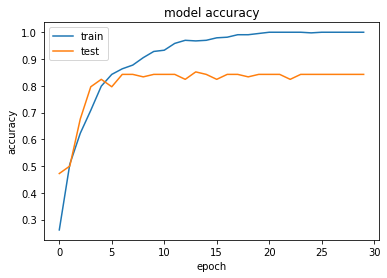

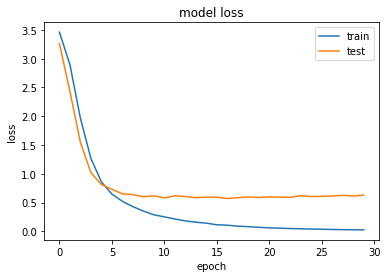

In [13]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()